## Pix2Pix - Change Detection

Reprodução do modelo de GAN (Generative Adversarial Netowork) conhecido como Pix2Pix para aplicação na tarefa de detecção de mudanças em imagens (*change detection*). A implementação foi baseada no artigo [CHANGE DETECTION IN REMOTE SENSING IMAGES USING
CONDITIONAL ADVERSARIAL NETWORKS](https://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XLII-2/565/2018/isprs-archives-XLII-2-565-2018.pdf) e aplica detecção de mudança em imagens de satélites
### Importando bibliotecas e o modelo
Os blocos abaixo temos todas as bibliotecas utilizadas e o modelo importado do arquivo E_Net.py, tome o cuidade para estar na mesma pasta desse arquivo notebook

In [1]:
#Importando módulos necessários
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import models
from torchsummary import summary
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import date

In [2]:
#Importando implementação da arquitetura da rede Pix2Pix
import Pix2Pix_Model as model

## Sumário do modelo

Nos blocos abaixo temos os códigos necessário para printar o sumário do modelo, podendo visualizar as camadas e informações como a quantidade de parâmetros. Como ele ocupa a gpu, tome cuidade em executar tais blocos, procure utilizá-los somente para testes

In [19]:
#Função utilizada para printar sumário do modelo do Discriminador
def print_discriminator_model():
    print("PatchGan model: \n\n")
    #Usamos 7 canais de cores como entrada
    Discriminator = model.PatchGAN_Discriminator(7)
    Discriminator.apply(model._initialize_weights)
    Discriminator.cuda()
    summary(Discriminator, (7, 256, 256))

In [4]:
print_discriminator_model()

PatchGan model: 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           7,232
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12          [-1, 512, 15, 15]       4,194,304
      BatchNorm2d-13          [-1, 512, 15, 15]           1,024
        LeakyReLU-14

In [11]:
#Função utilizada para printar sumário do modelo do Gerador
def print_generator_model():
    print("UNet model: \n\n")
    #Usamos 3 canais de cores como entrada
    Generator = model.UnetGenerator(3)
    Generator.apply(model._initialize_weights)
    Generator.cuda()
    summary(Generator, (3, 256, 256))

In [12]:
print_generator_model()

UNet model: 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,304
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14    

## Setando Device e Inicializando Modelos

In [4]:
#definindo device de acordo com a disponibilidade
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
print(torch.cuda.get_device_name(device))

cuda
GeForce GTX 1050


In [5]:
#initialize D, G
D = model.PatchGAN_Discriminator(7).to(device)
D.apply(model._initialize_weights)

G = model.UnetGenerator(6).to(device)
G.apply(model._initialize_weights)

print('Modelos Inicializados')

Modelos Inicializados


## Leitura dataset - Experimento 1
O primeiro experimento consiste na datecção de mudança em imagens de figuras geométricas simples

In [8]:
batch_size = 8

dataloader_A = model.load_dataset(batch_size,'ChangeDetectionDataset/Model/without_shift/train/A/',False)

dataloader_B = model.load_dataset(batch_size,'ChangeDetectionDataset/Model/without_shift/train/B/',False)

dataloader_OUT = model.load_dataset(batch_size,'ChangeDetectionDataset/Model/without_shift/train/OUT/',True)

### Testes Dataset

In [6]:
#Criando iteradores para o dataset
iterA = iter(dataloader_A)
iterB = iter(dataloader_B)
iterOUT= iter(dataloader_OUT)

In [7]:
'''Método next retorna array de imagens de acordo com o batch
(caso batch = 1 retorna array contendo somente uma imagem)
e a numeração da iteração atual'''
img_A, i_A = iterA.next()
img_B, i_B = iterB.next()
img_OUT, i_OUT = iterOUT.next()

print(type(img_A))
print(img_A.shape)
print(img_OUT.shape)
print(i_A)

<class 'torch.Tensor'>
torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


A image:  torch.Size([3, 256, 256])
B image:  torch.Size([3, 256, 256])
OUT image:  torch.Size([256, 256])
torch.Size([256, 256, 3])


Text(0.5, 1.0, 'Ground truth')

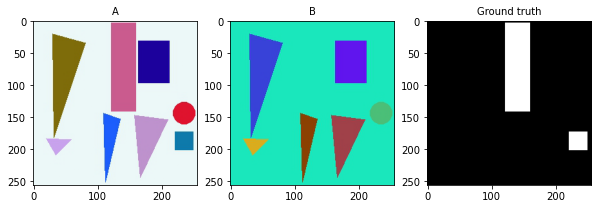

In [8]:
#Pegando imagem inicial da array de imagens como exemplo
single_img_A = img_A[0]
print("A image: ",single_img_A.shape)
single_img_B = img_B[0]
print("B image: ",single_img_B.shape)
#para plotar grayscale preciso somente de duas dimensões
single_img_OUT = img_OUT[0][0] 
print("OUT image: ", single_img_OUT.shape)
#Invertendo ordem das dimensões para consguir plotar no matplot
single_img_A = single_img_A.permute(1,2,0)
single_img_B = single_img_B.permute(1,2,0)
single_img_OUT = single_img_OUT.permute(0,1)
print(single_img_A.shape)

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10,15))

ax0.imshow(single_img_A)
ax0.set_title('A', fontsize=10)

ax1.imshow(single_img_B)
ax1.set_title('B', fontsize=10)

ax2.imshow(single_img_OUT, cmap='gray')
ax2.set_title('Ground truth', fontsize=10)

## Parâmetros do Modelo

In [9]:
#optimizers
optimizerD = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5,0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5,0.999))

#Loss Functions
criterionD = nn.BCELoss()
criterionG = nn.L1Loss()

In [10]:
# generate real matrix class labels (1)
lab_real = torch.ones(batch_size, 14, 14, device=device)
# generate fake matrix class labels (0)
lab_fake = torch.zeros(batch_size, 14, 14, device=device)

## Parâmetros de Log e Checkpoints

In [11]:
#Where save checkpoints' model
name_checkpoint = "model_withoutshift_original" + "2021-10-21"
#str(date.today())

path_model_checkpoints = 'checkpoints_model/' + name_checkpoint + '.tar'

print(path_model_checkpoints)

#set up tensorboard - runs folder
writerA = SummaryWriter('logs/'+ name_checkpoint + '_A_lrDG ')
writerB = SummaryWriter('logs/'+ name_checkpoint + '_B_lrDG ')
writerC = SummaryWriter('logs/'+ name_checkpoint + '_C_lrDG ')

checkpoints_model/checkpoint_8000_L2_5.tar.tar


## Parâmetros do treinamento

In [14]:
#Number of images from dataset that will use to train
num_data = len(dataloader_A)
print(num_data)
#Each number will print itens
batch_print = 200

num_epoch = 200
epoch_ini = 0

1000


### Carregamento de Modelos

In [15]:
path_checkpoint_load = 'checkpoints_model/checkpoint_8000_L2_5.tar'

import os
#Checando se o arquivo existe
if os.path.isfile(path_checkpoint_load):
    print("\nCarregando checkpoint de " + path_checkpoint_load)
    #Carregando informações salvas do modelo
    checkpoint = torch.load(path_checkpoint_load)
    epoch_ini = checkpoint['epoch']
    
    G.load_state_dict(checkpoint['Generator_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    lossG = checkpoint['loss_G']

    D.load_state_dict(checkpoint['Discriminator_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    lossD = checkpoint['loss_D']
    
    print("\nCarregado: '{}' \n Epoch: {} \n LossG: {} \n LossD: {}".format(path_checkpoint_load, epoch_ini, lossG, lossD))
    
else:
    print("Arquivo não encontrado !")



Carregando checkpoint de checkpoints_model/checkpoint_8000_L2_5.tar

Carregado: 'checkpoints_model/checkpoint_8000_L2_5.tar' 
 Epoch: 174 
 LossG: 14.985588073730469 
 LossD: 0.0017373173031955957


## Configurando visualização dos dados
Configurando o framework tensorboard para que seja possível visualizar dados como o progresso da perda, as imagens sendo geradas e etc.

In [3]:
#Criando configurações do tensorboard para visualização dos dados
writer_Tensorboard = SummaryWriter('logs')

In [4]:
logs_base_dir = 'logs'
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

## Algoritmo de Treino

In [27]:
for epoch in range(epoch_ini, num_epoch):
    #Creating iters for dataloader
    iterA = iter(dataloader_A)
    iterB = iter(dataloader_B)
    iterOUT= iter(dataloader_OUT)
    for i in range(num_data):
        #select a batch of real samples
        img_A, _ = iterA.next()
        img_B, _ = iterB.next()
        img_OUT, _ = iterOUT.next()

        img_A = img_A.to(device)
        img_B = img_B.to(device)
        img_OUT = img_OUT.to(device)

        #input of generator
        img_AB = model.concatenate_torch(img_A, img_B)
        #generate fake image
        img_Out_fake = G(img_AB)

        model.set_requires_grad(D,True)

        #Discriminator optimization step:

        #input of discriminator
        img_ABOut = model.concatenate_torch(img_AB,img_OUT)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()
        #updating for real samples
        D_x = D(img_ABOut)
        #Eliminate dimension not necessary
        D_x = torch.squeeze(D_x)
        #calculate loss for real label
        lossD_real = criterionD(D_x, lab_real)
        #updating for fake samples
        img_ABOut_fake = model.concatenate_torch(img_AB,img_Out_fake)
        D_G_x = D(img_ABOut_fake)
        D_G_x = torch.squeeze(D_G_x)
        #calculate loss for fake label
        lossD_fake = criterionD(D_G_x,lab_fake)
        # combine loss and calculate gradients
        lossD = (lossD_fake + lossD_real)*0.5
        lossD.backward(retain_graph=True)
        optimizerD.step()

        #Generator optimization step:
        model.set_requires_grad(D,False) #Discriminator don't need gradient to optmize generator
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()
        #generate image
        img_generate = G(img_AB)
        #Test like discriminator input
        img_gen_cat = concatenate_torch(img_AB,img_Out_fake)
        D_G_x2 = D(img_gen_cat)
        D_G_x2 = torch.squeeze(D_G_x2)
        #Calculate loss testing like real - adversarial loss
        lossAdversarial = criterionD(D_G_x2, lab_real)
        #Calculate L1 loss - compare with ground truth
        lossL1 = criterionG(img_Out_fake, img_OUT)
        '''
        The weights of the generator will be updated via both adversarial loss via the discriminator output and L1 loss 
        via the direct image output. The loss scores are added together, where the L1 loss is treated as a regularizing 
        term and weighted via a hyperparameter called lambda, set to 100.'''
        #loss = adversarial loss + lambda * L1 loss
        lossG = 1*lossAdversarial + 100*lossL1
        lossG.backward()
        optimizerG.step()


        if i % batch_print == 0: # every 100 batches...
            #making grid of images
            img_gridA = torchvision.utils.make_grid(img_A)
            img_gridB = torchvision.utils.make_grid(img_B)
            img_gridOut = torchvision.utils.make_grid(img_OUT)
            img_Out_fake[img_Out_fake < 0 ] = 0
            img_gridG = torchvision.utils.make_grid(img_Out_fake)
            #writing on tensorboard
            writerA.add_image('Image input A',img_gridA,(num_data*epoch) + (i+batch_print))
            writerA.add_image('Image input B',img_gridB,(num_data*epoch) + i)
            writerA.add_image('Image input Difference Map Ground Truth',img_gridOut,(num_data*epoch) + (i+batch_print))
            writerA.add_image('Image output Generator',img_gridG,(num_data*epoch) + (i+batch_print))
            #Printing loss
            print('Train Epoch: {} [{}/{} ({:.0f}%)]   D_Loss: {:.6f}  G_Loss: {:.6f}'.format(
                epoch+1, i+batch_print, num_data,
                100. * (i+batch_print) / num_data, lossD.item(), lossG.item()))

            #writing loss on tensorboard
            writerA.add_scalar('Training Loss - Discriminator',lossD.item(),(num_data*epoch) + (i+batch_print))
            writerB.add_scalar('Training Loss - Discriminator',lossD_real.item(),(num_data*epoch) + (i+batch_print))
            writerC.add_scalar('Training Loss - Discriminator',lossD_fake.item(),(num_data*epoch) + (i+batch_print))
            writerA.add_scalar('Training Loss - Generator',lossG.item(),(num_data*epoch) + (i+batch_print))
            writerB.add_scalar('Training Loss - Generator',100*lossL1.item(),(num_data*epoch) + (i+batch_print))
            writerC.add_scalar('Training Loss - Generator',lossAdversarial.item(),(num_data*epoch) + (i+batch_print))
    
    #Save checkpoints
    torch.save({
        'epoch':epoch+1,
        'Generator_state_dict': G.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'loss_G':lossG,
        'Discriminator_state_dict': D.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'loss_D':lossD
    }, path_model_checkpoints)                


print("Finished Training")

Train Epoch: 81 [200/1000 (20%)]   D_Loss: 0.000047  G_Loss: 21.595993
Train Epoch: 81 [400/1000 (40%)]   D_Loss: 0.000045  G_Loss: 24.248718
Train Epoch: 81 [600/1000 (60%)]   D_Loss: 0.000002  G_Loss: 37.856125
Train Epoch: 81 [800/1000 (80%)]   D_Loss: 0.000004  G_Loss: 22.683140
Train Epoch: 81 [1000/1000 (100%)]   D_Loss: 0.000055  G_Loss: 23.322456
Train Epoch: 82 [200/1000 (20%)]   D_Loss: 0.526619  G_Loss: 19.880821
Train Epoch: 82 [400/1000 (40%)]   D_Loss: 0.006710  G_Loss: 21.424517
Train Epoch: 82 [600/1000 (60%)]   D_Loss: 0.000070  G_Loss: 31.420662
Train Epoch: 82 [800/1000 (80%)]   D_Loss: 0.000177  G_Loss: 23.210119
Train Epoch: 82 [1000/1000 (100%)]   D_Loss: 0.000099  G_Loss: 24.636063
Train Epoch: 83 [200/1000 (20%)]   D_Loss: 0.000015  G_Loss: 22.394764
Train Epoch: 83 [400/1000 (40%)]   D_Loss: 0.000040  G_Loss: 23.848022
Train Epoch: 83 [600/1000 (60%)]   D_Loss: 0.000030  G_Loss: 22.535358
Train Epoch: 83 [800/1000 (80%)]   D_Loss: 0.000005  G_Loss: 19.088560
Tr